In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(404)

## Basic MCMC sampling

This notebook shows the following MCMC sampling methods for a multivariate Gaussian distribution

1. Random-Walk-Metropolis-Hastings (RWMH) 
2. Gibbs sampler
3. Metropolis adjusted Langevin algorithm


## Data

We will use 500 samples of a multivaraite Gaussian distribution with the following mean vector

\begin{equation}
\mu = \begin{pmatrix} 1 \\ 2\\ 3 \end{pmatrix}
\end{equation}

and covariance matrix 

\begin{equation}
\Sigma = \begin{pmatrix} 1 & -0.7 & -0.7 \\ -0.7 & 1.5 & 0.7 \\ -0.7 & 0.7 & 1 \end{pmatrix}
\end{equation}

In [21]:
#covariance matrix
Σ = np.array([[1,-0.7,-0.7],[-0.7,1.5,0.7],[-0.7,0.7,1]])
print("Eigenvlaues of Σ : {}".format(np.linalg.eigvals(Σ)))
#mean vector
μ = np.array([1,2,3])
#Generaate 500 samples
Y = pd.DataFrame(np.random.multivariate_normal(μ,Σ,size=500),columns=['x_1','x_2','x_3'])

Eigenvlaues of Σ : [2.59498744 0.3        0.60501256]


## Summary of generated samples

In [22]:
Y.describe().round(2)

,x_1,x_2,x_3
count,500.00,500.00,500.00
mean,0.98,2.01,3.01
std,1.04,1.24,1.07
min,-2.64,-1.94,-0.09
25%,0.20,1.19,2.30
50%,1.01,1.92,3.06
75%,1.73,2.86,3.76
max,4.10,5.76,6.64


## Define density 

\begin{equation}
        f(y|\mu,\Sigma) = (2\pi)^{-\frac{3}{2}}|\Sigma|^{-\frac{1}{2}} \exp{\left(-\frac{1}{2}(y-\mu)^{T}\Sigma^{-1}(y-\mu)\right)}
\end{equation}

In [4]:
def mvn_dens(x,Σ,μ):
    return 1/np.sqrt((2*np.pi)**3*np.linalg.det(Σ))*np.exp(-0.5*(x-μ).T@np.linalg.inv(Σ)@(x-μ))

## 1) RWMH algorithm

In [23]:
#initial guess
init = np.array([0.5,1.5,2.5])
n= 500
MCMC = [init]
s = init
accepted = 0
for i in range(n):
    s = MCMC[-1]
    #generate proposal sample
    y = np.random.multivariate_normal(s,1.0*np.eye(3))
    #compute acceptance rate
    α = mvn_dens(y,Σ,μ)/mvn_dens(s,Σ,μ)
    #accepte or reject
    if α > np.random.uniform(0,1):
        #if accepted append proposal sample to list of samples
        MCMC.append(y)
        accepted +=1
    else:
        #if rejected append current state to list of samples
        MCMC.append(s)

In [24]:
samples_hm = pd.DataFrame(np.asarray(MCMC),columns=['x_1','x_2','x_3'])

## Helper function to plot MCMC samples and compare it to generated data 

In [7]:
def plot(samples):
    fig = plt.figure(figsize=(10,10))
    ax1=plt.subplot2grid( (3,3), [0,0], 1, 1 )
    sns.histplot(data=Y,x="x_1",ax=ax1,color='black',alpha=0.4,label='True values')
    sns.histplot(data=samples,x="x_1",color='royalblue',ax=ax1,alpha=0.6,label='Sampled values')
    ax1.set_xlabel('')
    #ax1.legend()
    ax2=plt.subplot2grid( (3,3), [1,0], 1, 1 )
    sns.kdeplot(data=Y,x='x_1',y='x_2',ax=ax2,color='black',alpha=0.6)
    sns.scatterplot(data=samples,x='x_1',y='x_2',ax=ax2,color='royalblue',linewidth=0.25)
    ax2.set_xlabel('')
    #plt.plot( x2, y2 )
    #plt.subplot2grid( (3,3), [1,0], 1, 1 )
    ax3=plt.subplot2grid( (3,3), [1,1], 1, 1 )
    sns.histplot(data=Y,x="x_2",ax=ax3,color='black',alpha=0.4)
    sns.histplot(data=samples,x="x_2",color='royalblue',ax=ax3,alpha=0.6)
    ax3.set_ylabel('')
    ax3.set_xlabel('')
    ax4=plt.subplot2grid( (3,3), [2,0], 1, 1 )
    sns.kdeplot(data=Y,x='x_1',y='x_3',ax=ax4,color='black',alpha=0.6)
    sns.scatterplot(data=samples,x='x_1',y='x_3',ax=ax4,color='royalblue',linewidth=0.25)
    ax5=plt.subplot2grid( (3,3), [2,1], 1, 1 )
    sns.kdeplot(data=Y,x='x_2',y='x_3',ax=ax5,color='black',alpha=0.6)
    sns.scatterplot(data=samples,x='x_2',y='x_3',ax=ax5,color='royalblue',linewidth=0.25)
    ax5.set_ylabel('')
    ax6=plt.subplot2grid( (3,3), [2,2], 1, 1 )
    sns.histplot(data=Y,x="x_3",ax=ax6,color='black',alpha=0.4)
    sns.histplot(data=samples,x="x_3",color='royalblue',ax=ax6,alpha=0.6,linewidth=1)
    ax6.set_ylabel('')
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels,loc='center right',bbox_to_anchor=[0.82,0.59]);
    
    return fig

## Sampled values with RWMH vs generated data

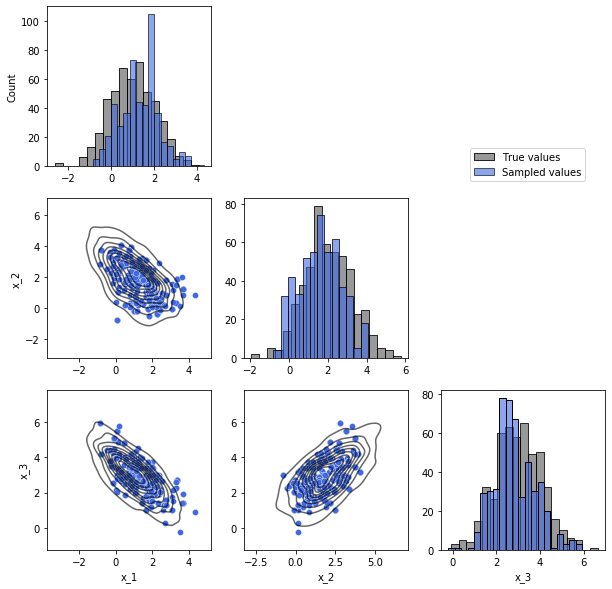

In [25]:
f=plot(samples_hm)

# 2) Gibbs sampler

## Define conditional distributions for Gibbs sampler

In [12]:
def coonditional(x,mu,Sigma,ind):
    if ind==2:
        x=np.array([x[1],x[0],x[2]])
        μ = np.array([mu[1],mu[0],mu[2]])
        Σ = np.array([[Sigma[1,1],Sigma[1,0],Sigma[1,2]],[Sigma[0,1],Sigma[0,0],Sigma[0,2]],[Sigma[2,1],Sigma[2,0],Sigma[2,2]]])
    elif ind==3:
        x=np.array([x[2],x[0],x[1]])
        μ = np.array([mu[2],mu[0],mu[1]])
        Σ = np.array([[Sigma[2,2],Sigma[2,0],Sigma[2,1]],[Sigma[0,2],Sigma[0,0],Sigma[0,1]],[Sigma[1,2],Sigma[1,0],Sigma[1,1]]])
    else:
        μ = mu
        Σ = Sigma
    new_mean=μ[0]+Σ[0,1:]@np.linalg.inv(Σ[1:,1:])@(x[1:]-μ[1:])
    cov = Σ[0,0]-Σ[0,1:]@np.linalg.inv(Σ[1:,1:])@Σ[1:,0]
    return np.random.normal(new_mean,cov)

In [26]:
init = np.array([0.5,1.5,2.5])
n= 500
MCMC = [init]
s = init
for i in range(n):
    s = MCMC[-1]
    a = coonditional(s,μ,Σ,1)
    s[0]=a
    b = coonditional(s,μ,Σ,2)
    s[1]=b
    c = coonditional(s,μ,Σ,3)
    s[2]=c
    MCMC.append(np.array([a,b,c]))

In [27]:
samples_Gibbs = pd.DataFrame(np.asarray(MCMC),columns=['x_1','x_2','x_3'])

## Sampled values with Gibbs sampler vs generated data

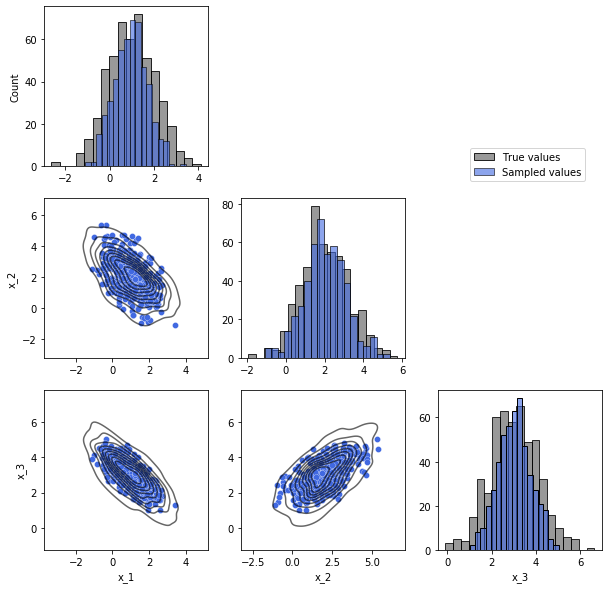

In [28]:
f_2=plot(samples_Gibbs)

## 3) Metropolis adjusted Langevin algorithm (MALA)

### Define gradient of log-likelihood wrt. to x

In [16]:
def d_log(x,μ,Σ):
    return -np.linalg.inv(Σ)@(x-μ)

### Genrate proposal sample $y$ according to 

\begin{equation}
y=s+\frac{h}{2}\nabla \log{\pi(s)} + hz.
\end{equation}

### where $s$ is the current state and $z \sim N(0,I_{3})$.

### The acceptance rate is 

\begin{equation}
\alpha = \min\left[1, \frac{f(y|\mu,\Sigma)q(s|y)}{f(s|\mu,\Sigma)q(y|s)}\right]
\end{equation}

### with

\begin{equation}
q(s|y) \propto \exp{\left( -\frac{1}{4h}||s-y-h\nabla \log{f(y|\mu,\Sigma)}||_{2}^{2}\right)}
\end{equation}

In [29]:
h = 0.4
init = np.array([0.5,1.5,2.5])
n= 1000
MCMC = [init]
s = init
accepted = 0
for i in range(n):
    s = MCMC[-1]
    #generate proposal sample y
    y = s + h/2*d_log(s,μ,Σ) + (2*h)**0.5*np.random.multivariate_normal(np.zeros(3),np.eye(3))
    #compute q(y|s)
    rxy = np.exp(-np.linalg.norm(y-s-h*d_log(s,μ,Σ))**2/(4*h))
    #compute q(s|y)
    ryx = np.exp(-np.linalg.norm(s-y-h*d_log(y,μ,Σ))**2/(4*h))
    #compute acceptance rate
    α = (mvn_dens(y,Σ,μ)*ryx)/(mvn_dens(s,Σ,μ)*rxy)
    #accepting/rejecting
    if α > np.random.uniform(0,1):
        MCMC.append(y)
        accepted +=1
    else:
        MCMC.append(s)
print(accepted/1000)

0.659


In [30]:
samples_LHM = pd.DataFrame(np.asarray(MCMC[500:]),columns=['x_1','x_2','x_3'])

## Sampled values with MALA (stepsize 0.4) vs generated data

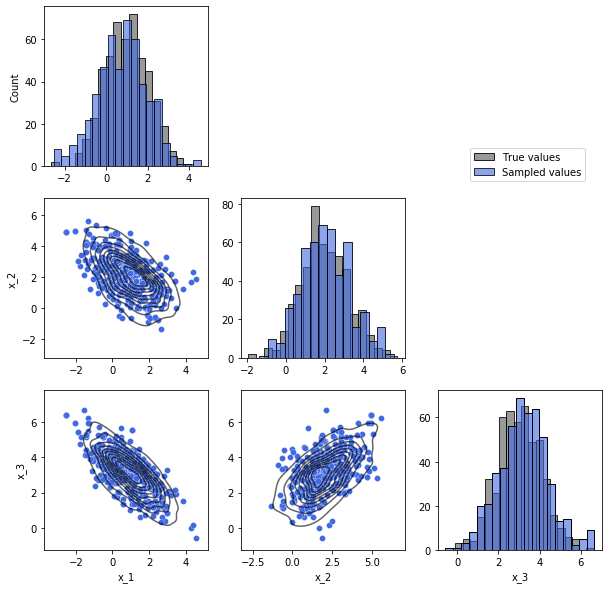

In [31]:
f_3 = plot(samples_LHM)